<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Extraction-and-Analysis" data-toc-modified-id="Data-Extraction-and-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Extraction and Analysis</a></span><ul class="toc-item"><li><span><a href="#Data-extraction" data-toc-modified-id="Data-extraction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data extraction</a></span></li><li><span><a href="#Visualizing-extracted-data's-spectra" data-toc-modified-id="Visualizing-extracted-data's-spectra-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualizing extracted data's spectra</a></span></li></ul></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest Classifier</a></span><ul class="toc-item"><li><span><a href="#Training-the-model-and-obtaining-test-set-scores" data-toc-modified-id="Training-the-model-and-obtaining-test-set-scores-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Training the model and obtaining test set scores</a></span></li><li><span><a href="#Comparing-train-and-test-set-errors-(check-for-overfitting)" data-toc-modified-id="Comparing-train-and-test-set-errors-(check-for-overfitting)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Comparing train and test set errors (check for overfitting)</a></span></li></ul></li><li><span><a href="#Visualizing-Test-Set-Results" data-toc-modified-id="Visualizing-Test-Set-Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing Test Set Results</a></span><ul class="toc-item"><li><span><a href="#[Fig.-1]-Test-Scores,-Confusion-Matrix,-Individual-Class-Scores" data-toc-modified-id="[Fig.-1]-Test-Scores,-Confusion-Matrix,-Individual-Class-Scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>[Fig. 1] Test Scores, Confusion Matrix, Individual Class Scores</a></span></li><li><span><a href="#[Fig.-2]-Feature-Importance-Chart" data-toc-modified-id="[Fig.-2]-Feature-Importance-Chart-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>[Fig. 2] Feature Importance Chart</a></span></li><li><span><a href="#[Fig.-3]-Performance-on-Full-Test-Images" data-toc-modified-id="[Fig.-3]-Performance-on-Full-Test-Images-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>[Fig. 3] Performance on Full Test Images</a></span></li></ul></li></ul></div>

# Data Extraction and Analysis

Extracting data based off functions from *utility_functions.py*, and splitting the data into train and test sets, before analyzing their spectra (pixel value distribution). 

Documentations for `extractData` & `plotSpectra` can be found in *utility_functions.py*.

## Data extraction

In [1]:
# Resetting everythng and importing only necessary functions.
%reset -f
import numpy as np
from utility_functions import *
%matplotlib inline

# Defining settings for data extraction
    # CHANGE ALL 3 VARIABLES BASED ON WHAT YOU WANT THE ALGORITHM TO TRAIN ON (see extractData documentation for more details).
dataDir = r'C:\Users\ansel\Desktop\MSS Internship Stuff\Data' # CHANGE THIS TO YOUR OWN DATA FOLDER
setting = [('S2', 'fire'), ('S2', 'lava'), ('LS8', 'lava')] 
settingRatio = [1, 1, 2]

# Defining boolean that indicates if all hotspot classes are collated and converted into a single hotspot class ('hotspot').
# Then defining the list of unique hotspot classes.
combinedHotspot = False
if combinedHotspot:
    hotspotClasses = ['hotspot',]
else:
    hotspotClasses = set(list(zip(*setting))[-1])

# Extracting data into predictor (X) and target (y) variables.
X, y, features = extractData(dataDir, setting, settingRatio=settingRatio, totalImages=86, combinedHotspot=combinedHotspot)

# Defining the string that represents the setting based on setting & settingRatio.
if len(setting) == 1:
    settingStr = '-'.join(setting[0])
else:
    settingStr = '  '.join(['-'.join(ratioPair) for ratioPair in list(zip(list(map(str,settingRatio)),['-'.join(pair) for pair in setting]))])
    
print('Setting selected for the upcoming model: %s' % (settingStr))

Setting selected for the upcoming model: 1-S2-fire  1-S2-lava  2-LS8-lava


## Visualizing extracted data's spectra

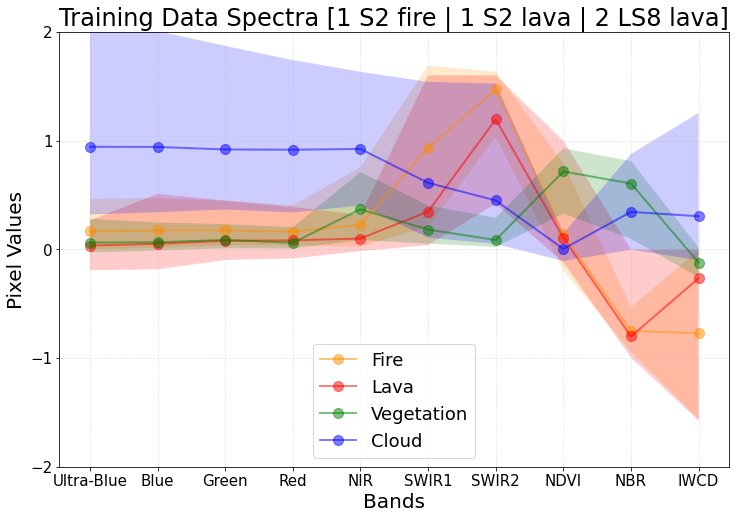

In [2]:
# Splitting the data into train and test sets, and visualizing the train set's spectra thereafter.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=1)

# Obtaining all classes in y_train
classes = np.unique(y_train)

# Defining variables needed for plotSpectra
    # Adding in fire, lava and/or hotspot classSets based on their availability in hotspotClasses
classSet = [('vegetation','green'), ('cloud','blue')]
for hotspotClass in hotspotClasses:
    if hotspotClass == 'fire':
        classSet.insert(0, ('fire','darkorange'))
    elif hotspotClass == 'lava':
        classSet.insert(0, ('lava','red'))
    elif hotspotClass == 'hotspot':
        classSet.insert(0, ('hotspot','brown'))
_ = plotSpectra(X_train, y_train, classSet, settingStr, features, plotShow = True, saveFig = None)

# Random Forest Classifier

The model is defined and then trained with pre-tuned hyperparameters (cross validation code not included) on the training data, before being used on the test data. Subsequently, the training and testing error (1 - score) is then compared and displayed below.

A threshold can then be applied to y_predictedProba such that the classes (i.e., lava) in y_predicted will remain so only if their corresponding probability in y_predictedProba exceeds a defined threshold in `setThreshold`.

Documentations for `getTrainingError` and `setThreshold` can be found in *utility_functions.py*.

## Training the model and obtaining test set scores

In [3]:
# Importing the necessary libraries.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
beta = 1 # Ensuring we're calculating F1-score (F-beta)


# Defining the model with hardcoded hypereparameters (pre-tuned for all types of settings presented in the paper).
    # n_jobs=-1 is just for the model to train and test faster.
rf = RandomForestClassifier(n_estimators=200, random_state=1, criterion='entropy',
                           bootstrap=False, class_weight='balanced', min_samples_leaf=1,
                           max_depth=70, max_features='sqrt', min_samples_split=2,
                           ccp_alpha=0, n_jobs=-1)

# Training the model
rf.fit(X_train,y_train)

# Testing the model
    # y_predicted is the predicted labels for each pixel in the test set.
    # y_predictedProba is the computed probability of each predicted label in y_predicted.
y_predicted = rf.predict(X_test)
y_predictedProba = rf.predict_proba(X_test)

# Thresholding (currently set to None so nothing changes)
threshold = None
for hotspotClass in hotspotClasses: # Looping through each unique hotspot class in setting.
    hotspotClassIdx = classes.tolist().index(hotspotClass)
    y_predicted, y_predictedProba = setThreshold(y_predicted, y_predictedProba, 
                                                 hotspotClass, hotspotClassIdx, threshold = threshold) 
    
    
# Obtaining results of test score (precision, recall and f1-score) for each class individually
scores = precision_recall_fscore_support(y_test, y_predicted, average=None, beta=beta, labels=np.unique(y_train))

## Comparing train and test set errors (check for overfitting)

In [4]:
# Printing test vs train error (1 - score) 
for hotspotClass in hotspotClasses:
    
    # Getting index of hotspotClass
    hotspotClassIdx = classes.tolist().index(hotspotClass)
    
    # Comparing training error vs testing error
    # Comparing only precision, recall & fScore (hence the condition in the list comprehension)
        # Training error is calculated based on 10-fold CV on subsets of the training data.
    compareTestErr = 1 - np.array([x[hotspotClassIdx] for xIdx,x in enumerate(scores) if xIdx != len(scores)-1])
    _ = getTrainingError(rf, X_train, y_train, hotspotClass, k=10, verbosity=True, compareTestErr=compareTestErr)

Arbitrary Training Error for class lava (10-fold CV of training dataset) | Computed Test Error
Precision Error: (Training) 0.0533 with std of 0.0431 | (Testing) 0.0441
Recall Error: (Training) 0.129 with std of 0.0683 | (Testing) 0.188
fScore Error: (Training) 0.0943 with std of 0.0452 | (Testing) 0.122


Arbitrary Training Error for class fire (10-fold CV of training dataset) | Computed Test Error
Precision Error: (Training) 0.0481 with std of 0.0248 | (Testing) 0.0688
Recall Error: (Training) 0.0194 with std of 0.0158 | (Testing) 0.0146
fScore Error: (Training) 0.0342 with std of 0.0156 | (Testing) 0.0425




# Visualizing Test Set Results

This notebook contains 3 primary ways to plot the results of the model to give a sense of its performance.

**1) Fig. 1** --- Printing out the test scores for only the hotspot class, the confusion matrix, and a graph of individual score for all classes within a single figure.

**2) Fig. 2** --- Feature importances for all bands for the trained model.

**3) Fig. 3** -- Deploying the model on full images based on whatever hotspot class available in `hotspotClasses`. This figure contains the original image, the class-predicted image, and an image displaying the probabilities of all predicted hotspot classes. All 3 images in this figure follow the same format.

Documentations for `Fig. 1`, `Fig. 2` and `Fig. 3` can be found in *utility_functions.py*. Additionally, the function `mapColors` that was used in `Fig.3` is also found in the same file.

## [Fig. 1] Test Scores, Confusion Matrix, Individual Class Scores

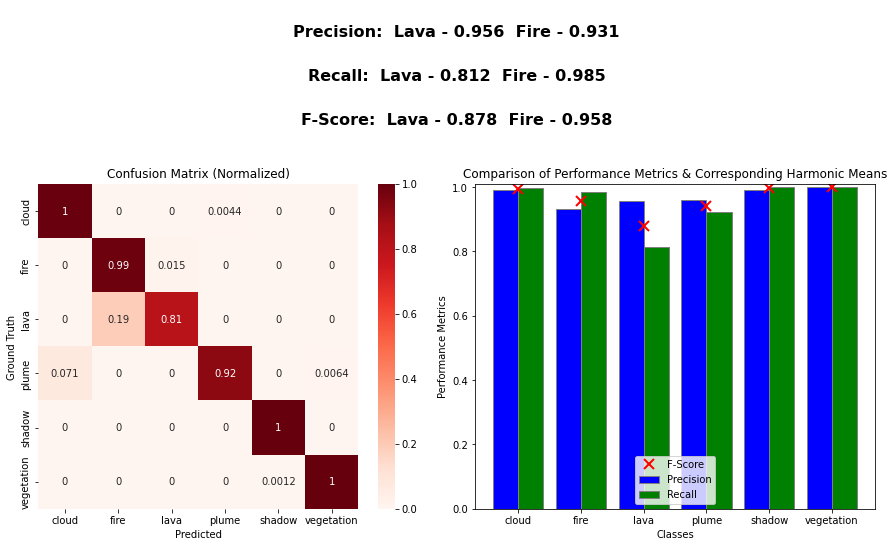

In [5]:
# Defining the confusion matrix in pure (unedited) form needed for Fig. 1
cm = confusion_matrix(y_test, y_predicted, labels=classes)

# Plotting Figure 1
plotFig1(scores, classes, hotspotClasses, cm, plotShow=True, saveFig=None)

## [Fig. 2] Feature Importance Chart

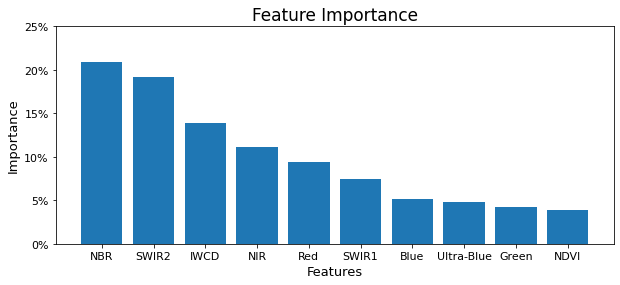

In [6]:
# First defining the feature importances of the model.
featureImportances = rf.feature_importances_

# Plotting the feature importance chart
plotFig2(featureImportances, features, ylimUpper = 0.25, plotShow = True, saveFig = None)

## [Fig. 3] Performance on Full Test Images

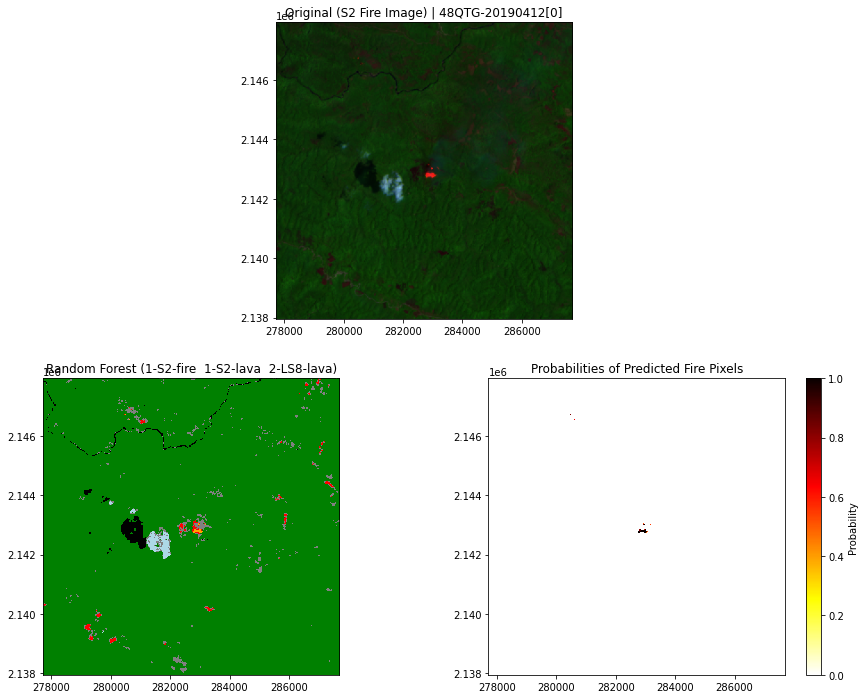

In [7]:
# First defining the full test image's raster file that we want the model to predict.
testFilename = r'C:\Users\ansel\Desktop\MSS Internship Stuff\Data\Fire Images\S2\48QTG-20190412[0]\raster.tif'
testThreshold = None # We dont want any thresholding of the hotspot classes after prediction, and so we set it to None.

# Plotting the model's performance on a full test image.
plotFig3(rf, testFilename, settingStr, classes, testThreshold, plotShow=True, saveFig=None)